Marcin Wardyński  
wtorek, 9:45

## Laboratorium 7
### 7.3 RBM - własna implementacja

In [3]:
import importlib
import lab7_utils as utils
importlib.reload(utils)

/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'lab7_utils' from '/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/lab7/lab7_utils.py'>

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import os
import imageio

class RBM:
    def __init__(self, visible_dim, hidden_dim):
        self.visible_dim = visible_dim
        self.hidden_dim = hidden_dim
        # Initialize weights and biases
        self.weights = np.random.normal(0, 0.01, (visible_dim, hidden_dim))
        self.visible_bias = np.zeros(visible_dim)
        self.hidden_bias = np.zeros(hidden_dim)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def fit(self, X, epochs=10, batch_dim=50, lr=0.1, output_dir="weights_plots"):
        num_samples = X.shape[0]
        
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        for epoch in range(epochs):
            np.random.shuffle(X)  # Shuffle the data
            
            for batch_start in range(0, num_samples, batch_dim):
                batch = X[batch_start:batch_start + batch_dim]

                # Wake phase: Compute probabilities of hidden layer given visible
                hidden_probs = self.sigmoid(np.dot(batch, self.weights) + self.hidden_bias)
                hidden_states = (hidden_probs > np.random.rand(*hidden_probs.shape)).astype(float)

                # Dream phase: Reconstruct visible from hidden
                visible_recon_probs = self.sigmoid(np.dot(hidden_states, self.weights.T) + self.visible_bias)
                visible_recon_states = (visible_recon_probs > np.random.rand(*visible_recon_probs.shape)).astype(float)

                # Recalculate hidden probabilities from reconstructed visible
                hidden_recon_probs = self.sigmoid(np.dot(visible_recon_states, self.weights) + self.hidden_bias)

                # Contrastive Divergence
                positive_gradient = np.dot(batch.T, hidden_probs)
                negative_gradient = np.dot(visible_recon_states.T, hidden_recon_probs)

                self.weights += lr * (positive_gradient - negative_gradient) / batch_dim
                self.visible_bias += lr * np.mean(batch - visible_recon_states, axis=0)
                self.hidden_bias += lr * np.mean(hidden_probs - hidden_recon_probs, axis=0)

            # Save weight visualization for the current epoch
            self.plot_weights(step=epoch + 1, output_dir=output_dir)

            # Calculate reconstruction error
            error = np.mean((X - self.sigmoid(np.dot(self.sigmoid(np.dot(X, self.weights) + self.hidden_bias), self.weights.T) + self.visible_bias)) ** 2)
            print(f"Epoch {epoch + 1}/{epochs}, Reconstruction Error: {error:.4f}")

        # Create a GIF from saved plots
        self.create_gif(output_dir)

    def reconstruct(self, X):
        hidden_probs = self.sigmoid(np.dot(X, self.weights) + self.hidden_bias)
        reconstructed = self.sigmoid(np.dot(hidden_probs, self.weights.T) + self.visible_bias)
        return reconstructed

    def plot_weights(self, step=0, output_dir="weights_plots"):
        plt.figure(figsize=(10, 10))
        for i in range(min(100, self.hidden_dim)):
            plt.subplot(10, 10, i + 1)
            plt.imshow(self.weights[:, i].reshape(int(np.sqrt(self.visible_dim)), -1), cmap='gray')
            plt.axis('off')
        plt.suptitle(f'Weight Visualization (Step {step})')
        plt.savefig(f"{output_dir}/weights_epoch_{step:03d}.png")
        plt.close()

    def plot_reconstruction(self, original, reconstructed):
        num_images = min(10, original.shape[0])
        plt.figure(figsize=(20, 4))

        for i in range(num_images):
            # Plot original
            plt.subplot(2, num_images, i + 1)
            plt.imshow(original[i].reshape(int(np.sqrt(self.visible_dim)), -1), cmap='gray')
            plt.title("Original")
            plt.axis('off')

            # Plot reconstructed
            plt.subplot(2, num_images, i + 1 + num_images)
            plt.imshow(reconstructed[i].reshape(int(np.sqrt(self.visible_dim)), -1), cmap='gray')
            plt.title("Reconstructed")
            plt.axis('off')

        plt.suptitle("Original and Reconstructed Images")
        plt.show()

    def compute_ssim(self, original, reconstructed):
        data_range = 1.0
        num_images = original.shape[0]
        ssim_values = []
        for i in range(num_images):
            orig_img = original[i].reshape(int(np.sqrt(self.visible_dim)), -1)
            recon_img = reconstructed[i].reshape(int(np.sqrt(self.visible_dim)), -1)
            ssim_values.append(ssim(im1=orig_img, im2=recon_img, data_range=data_range))
        return np.mean(ssim_values)

    def create_gif(self, output_dir):
        images = []
        for filename in sorted(os.listdir(output_dir)):
            if filename.endswith(".png"):
                file_path = os.path.join(output_dir, filename)
                images.append(imageio.imread(file_path))
        gif_path = os.path.join(output_dir, "weights_visualization.gif")
        imageio.mimsave(gif_path, images, duration=0.5)
        print(f"GIF saved at {gif_path}")


In [33]:
X_train, X_test, y_train, y_test = utils.get_dataset(dataset_name=utils.Dataset_Select.F_MNIST.value, print_sample_number=0)

In [34]:
import numpy as np

# Generate synthetic data (e.g., binary images)
num_samples = 1000
visible_dim = 28 * 28  # For example, 28x28 pixel images
hidden_dim = 128


# Initialize and train the RBM
rbm = RBM(visible_dim=visible_dim, hidden_dim=hidden_dim)
rbm.fit(X_train)

# Reconstruct some data
sample = X_train[:10]
reconstructed_sample = rbm.reconstruct(sample)

Epoch 1/10, Reconstruction Error: 0.0598
Epoch 2/10, Reconstruction Error: 0.0493
Epoch 3/10, Reconstruction Error: 0.0451
Epoch 4/10, Reconstruction Error: 0.0427
Epoch 5/10, Reconstruction Error: 0.0413
Epoch 6/10, Reconstruction Error: 0.0403
Epoch 7/10, Reconstruction Error: 0.0396
Epoch 8/10, Reconstruction Error: 0.0390
Epoch 9/10, Reconstruction Error: 0.0385
Epoch 10/10, Reconstruction Error: 0.0382


/var/folders/cd/rgg857vd6xggr1p8_8d98kzr0000gn/T/ipykernel_5623/699840368.py:110: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


GIF saved at weights_plots/weights_visualization.gif


```
Epoch 1/10, Reconstruction Error: 0.0598
Epoch 2/10, Reconstruction Error: 0.0493
Epoch 3/10, Reconstruction Error: 0.0451
Epoch 4/10, Reconstruction Error: 0.0427
Epoch 5/10, Reconstruction Error: 0.0413
Epoch 6/10, Reconstruction Error: 0.0403
Epoch 7/10, Reconstruction Error: 0.0396
Epoch 8/10, Reconstruction Error: 0.0390
Epoch 9/10, Reconstruction Error: 0.0385
Epoch 10/10, Reconstruction Error: 0.0382
/var/folders/cd/rgg857vd6xggr1p8_8d98kzr0000gn/T/ipykernel_5623/699840368.py:110: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))
GIF saved at weights_plots/weights_visualization.gif
```

In [35]:
rbm.create_gif("weights_plots")

/var/folders/cd/rgg857vd6xggr1p8_8d98kzr0000gn/T/ipykernel_5623/699840368.py:110: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


GIF saved at weights_plots/weights_visualization.gif


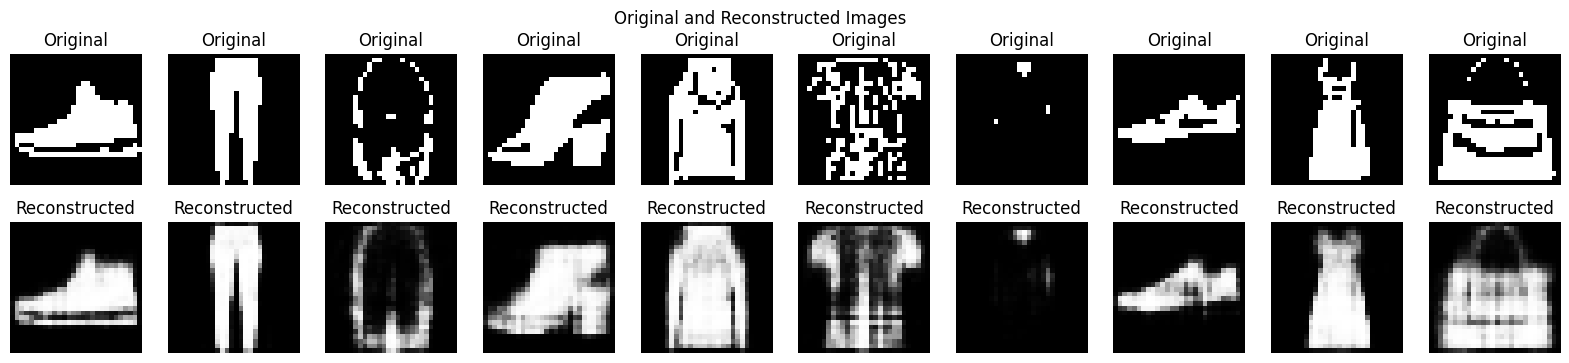

np.float64(0.6506044114907185)

In [36]:

rbm.plot_reconstruction(sample, reconstructed_sample)
rbm.compute_ssim(sample, reconstructed_sample)